# import

In [ ]:
### embedd ไทย
# # 50-unit embeddings
!gdown --id 14lAF3cOiYkcagFvNnW4o9BKIDXMB0RPg

# # 100-unit embeddings
!gdown --id 14bv_aTSP-8rs_Bkudvpp8zcU3UpyRen6

# # 200-unit embeddings
!gdown --id 14k1PLN9MVszCK6zUIRcLzWLwEGdR0ABw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14lAF3cOiYkcagFvNnW4o9BKIDXMB0RPg
To: /content/TNC_embeddings-50.bin
100% 13.6M/13.6M [00:00<00:00, 276MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14bv_aTSP-8rs_Bkudvpp8zcU3UpyRen6
To: /content/TNC_embeddings-100.bin
100% 25.9M/25.9M [00:00<00:00, 185MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downl

In [ ]:
!pip install pythainlp
import pythainlp as pyth
import pandas as pd
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 20.5 MB/s 


In [ ]:
train = pd.read_csv('/content/train.csv')
dev = pd.read_csv('/content/dev.csv')

In [ ]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
    )
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Load the word embeddings and the data

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format('/content/TNC_embeddings-100.bin', binary=True,limit=500000, unicode_errors='ignore')
vocab_size = len(w2v_model.vocab)
vector_dim = w2v_model.vector_size
# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+1, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.vocab)}
# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0 

for i, word in enumerate(w2v_model.vocab):
    embedding_matrix[i+1] = w2v_model[word] 

def convert_words(df, word_to_index, max_length):
    tokens = df['text'].apply(lambda x: pyth.word_tokenize(x)) #ทำการ splitt text
    list_of_list_of_indices = list(tokens.map(lambda x: [word_to_index.get(word, 0) for word in x]))
    return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=0, truncating='post')

In [ ]:
# max length (กำหนดเอง)
max_len = 600
train_x = convert_words(train, word_to_index, max_len)
dev_x = convert_words(dev, word_to_index, max_len)
num_classes = 4

def get_label(df):
    star_to_label = {'favorable':0, 'other':1, 'partially favorable':2, 'unfavorable':3}
    # apply functions & convert to np.array
    label = np.array(df['label'].replace(star_to_label).tolist())
    df['label'] = label
    return to_categorical(label, num_classes=num_classes)

# label : one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)

# Train the models

In [ ]:
def make_cnn_model(print_model=True):
    filters = 150 #number of filters in your Convnet
    kernel_size = 45 # a window size of tokens
    hidden_dims = 150 #number of neurons at the normal feedforward NN
    
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=vocab_size+1,
                        input_length=max_len,
                        output_dim=vector_dim, 
                        weights=[embedding_matrix], 
                        #mask_zero=True,
                        trainable=True))

    cnn_model.add(Conv1D(filters,
                        kernel_size,
                        input_shape=(max_len ,vector_dim),
                        #padding='valid',
                        activation='relu',
                        strides=1,))
    cnn_model.add(GlobalMaxPooling1D())
    #GlobalMaxPooling1D(n) default = 2.
    cnn_model.add(Dense(hidden_dims, activation='relu'))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(Dense(4, activation='softmax'))
    # compile model
    cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    if print_model:
        cnn_model.summary()
        plot_model(cnn_model, show_shapes=True,to_file='model.png')
        # display_png(Image('model.png'))
    return cnn_model

In [ ]:
cnn_model = make_cnn_model()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_126 (Embedding)   (None, 600, 100)          6165900   
                                                                 
 conv1d_126 (Conv1D)         (None, 556, 150)          675150    
                                                                 
 global_max_pooling1d_126 (G  (None, 150)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_252 (Dense)           (None, 150)               22650     
                                                                 
 dropout_126 (Dropout)       (None, 150)               0         
                                                                 
 dense_253 (Dense)           (None, 4)                 604       
                                                    

In [ ]:
# train
cnn_history = cnn_model.fit(train_x, train_y, batch_size=96, epochs=12, validation_data=(dev_x, dev_y))

Epoch 1/12
4/4 [==============================] - 1s 116ms/step - loss: 4.2550 - accuracy: 0.3158 - val_loss: 1.3575 - val_accuracy: 0.5395
Epoch 2/12
4/4 [==============================] - 0s 46ms/step - loss: 1.5264 - accuracy: 0.6020 - val_loss: 1.6197 - val_accuracy: 0.4868
Epoch 3/12
4/4 [==============================] - 0s 44ms/step - loss: 0.9916 - accuracy: 0.6809 - val_loss: 0.9521 - val_accuracy: 0.6184
Epoch 4/12
4/4 [==============================] - 0s 41ms/step - loss: 0.5921 - accuracy: 0.7862 - val_loss: 0.8971 - val_accuracy: 0.7500
Epoch 5/12
4/4 [==============================] - 0s 41ms/step - loss: 0.3569 - accuracy: 0.8750 - val_loss: 1.0438 - val_accuracy: 0.6711
Epoch 6/12
4/4 [==============================] - 0s 41ms/step - loss: 0.3515 - accuracy: 0.9112 - val_loss: 0.8856 - val_accuracy: 0.7632
Epoch 7/12
4/4 [==============================] - 0s 41ms/step - loss: 0.2661 - accuracy: 0.9046 - val_loss: 0.7484 - val_accuracy: 0.7895
Epoch 8/12
4/4 [==========

In [ ]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.88      0.50      0.64        14
           2       0.75      0.88      0.81        24
           3       0.79      0.95      0.86        20

    accuracy                           0.80        76
   macro avg       0.82      0.78      0.78        76
weighted avg       0.81      0.80      0.79        76



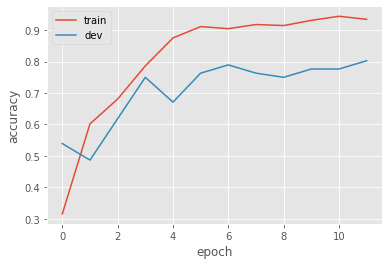

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

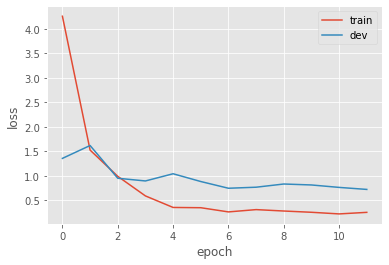

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
cnn_model.evaluate(dev_x, dev_y)[1]

3/3 [==============================] - 0s 6ms/step - loss: 0.7245 - accuracy: 0.8026


0.8026315569877625

# train + fine tune แล้ว
- TNC_embeddings-100.bin
- max len = 600
- filters = 150
- kernel_size = 45
- hidden_dims = 150
- trainable=True
- GlobalMaxPooling1D(n) default = 2
- strides=1

(ปล. ผลค่อนข้างเหวี่ยง หา parameter ที่ทุกครั้งที่ลอง train แล้วได้ผลใกล้เคียงเดิมค่อนข้างลำบาก อย่างมากคือหาได้เป็น f1 ที่ดีที่สุดเท่านั้น)

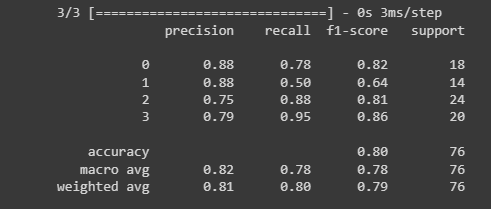

# New Model with new data

In [ ]:
def make_cnn_model(print_model=True):
    filters = 75 #number of filters in your Convnet
    kernel_size = 45 # a window size of tokens
    hidden_dims = 400 #number of neurons at the normal feedforward NN

    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=vocab_size+1,
                        input_length=max_len,
                        output_dim=vector_dim, 
                        weights=[embedding_matrix], 
                        #mask_zero=True,
                        trainable=True))

    cnn_model.add(Conv1D(filters,
                        kernel_size,
                        input_shape=(max_len ,vector_dim),
                        #padding='valid',
                        activation='relu',
                        strides=2,))
    cnn_model.add(GlobalMaxPooling1D())
    #GlobalMaxPooling1D(n) default = 2.
    cnn_model.add(Dense(hidden_dims, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(4, activation='softmax'))
    # compile model
    cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    if print_model:
        cnn_model.summary()
        plot_model(cnn_model, show_shapes=True,to_file='model.png')
        # display_png(Image('model.png'))
    return cnn_model

In [ ]:
cnn_model = make_cnn_model()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_104 (Embedding)   (None, 600, 100)          6165900   
                                                                 
 conv1d_104 (Conv1D)         (None, 278, 75)           337575    
                                                                 
 global_max_pooling1d_104 (G  (None, 75)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_202 (Dense)           (None, 400)               30400     
                                                                 
 dropout_101 (Dropout)       (None, 400)               0         
                                                                 
 dense_203 (Dense)           (None, 4)                 1604      
                                                    

In [ ]:
# train
cnn_history = cnn_model.fit(train_x, train_y, batch_size=128, epochs=12, validation_data=(dev_x, dev_y))

Epoch 1/12
3/3 [==============================] - 1s 144ms/step - loss: 2.2193 - accuracy: 0.3900 - val_loss: 1.3229 - val_accuracy: 0.4533
Epoch 2/12
3/3 [==============================] - 0s 52ms/step - loss: 1.2309 - accuracy: 0.5200 - val_loss: 0.9721 - val_accuracy: 0.5867
Epoch 3/12
3/3 [==============================] - 0s 49ms/step - loss: 0.7211 - accuracy: 0.7667 - val_loss: 0.9615 - val_accuracy: 0.6933
Epoch 4/12
3/3 [==============================] - 0s 50ms/step - loss: 0.4807 - accuracy: 0.8433 - val_loss: 0.9040 - val_accuracy: 0.7600
Epoch 5/12
3/3 [==============================] - 0s 48ms/step - loss: 0.3063 - accuracy: 0.9067 - val_loss: 0.8261 - val_accuracy: 0.7733
Epoch 6/12
3/3 [==============================] - 0s 50ms/step - loss: 0.2516 - accuracy: 0.9167 - val_loss: 0.8818 - val_accuracy: 0.7733
Epoch 7/12
3/3 [==============================] - 0s 50ms/step - loss: 0.2066 - accuracy: 0.9200 - val_loss: 0.9361 - val_accuracy: 0.7600
Epoch 8/12
3/3 [==========

In [ ]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.86      0.46      0.60        13
           2       0.88      0.84      0.86        25
           3       0.80      0.92      0.86        26

    accuracy                           0.80        75
   macro avg       0.79      0.76      0.76        75
weighted avg       0.81      0.80      0.79        75



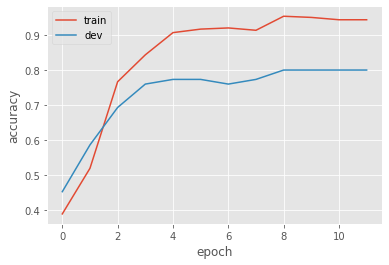

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

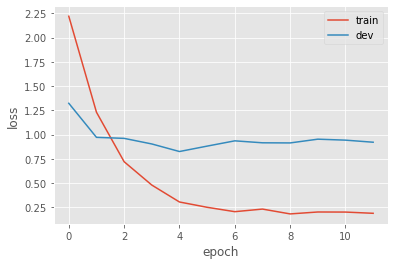

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
cnn_model.evaluate(dev_x, dev_y)[1]

3/3 [==============================] - 0s 5ms/step - loss: 0.9218 - accuracy: 0.8000


0.800000011920929

# new model best score

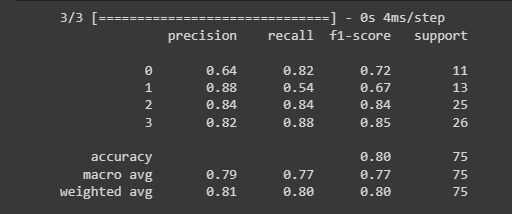

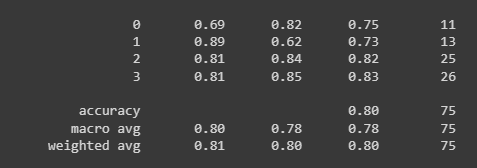